In [1]:
__author__ = 'Linda Jaber, NYU CUSP 2018'
from __future__ import print_function

import sys
import os

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
    
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import matplotlib as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
PUIdata = os.getenv('PUIDATA')
if PUIdata is None:
    os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
    PUIdata = os.getenv('PUIDATA')
print('PUIdata: ', PUIdata)

PUIdata:  /nfshome/lj1232/PUIdata


In [3]:
!ls $PUIdata/shapefiles/

shapefile_Census_Tracts_NYC_2010		     shapefile_PUMA_NYC
shapefile_Lebanon_Administrative_Boundaries_level_1  shapefile_Tree_Data_2015
shapefile_Lebanon_Administrative_Boundaries_level_2  shapefile_ZIP_Code_NYC
shapefile_Lebanon_Settlements


## Getting data about the informal refugee settelements in Lebanon

In [4]:
# download the excel file from https://data.humdata.org/dataset/informal-settlements-refugees-living-in-informal-settlements
    
file = './listofinformalsettlements_29_dec_2016.xlsx'
x1 = pd.ExcelFile(file)
print(x1.sheet_names)

['Summary Sheet', 'listofinformalsettlements_29_de', 'IAMP34 New Sites', 'IAMP34 Status Change', 'ESRI_MAPINFO_SHEET']


In [5]:
df1 = x1.parse('listofinformalsettlements_29_de')
df1.head()

,Pcode,Pcode Name,Governorate,District,Cadaster,Local Name,Latitude,Longitude,Shelter Type,Status,...,Water Capacity in L,Number of SSBs,Number of Ind in SSBs,Type of Water Source,Waste Disposal,Waste Water Disposal,Type of Contract,Type of Internet Connection,Consultation Fee for PHC (3000/5000),Free Vaccination for Children under 12
0,10650-01-001,Achrafieh foncière 001,Beirut,Beirut,Achrafieh foncière,Adleye,33.877880,35.523529,IS- Informal Settlement,Active,...,0,2,10,Water Trucking,Municipality Collection,Cesspit,Verbal,Wifi / local Internet service provider,No,No
1,21133-01-001,Furn Ech-Chebbak 001,Mount Lebanon,Baabda,Furn Ech-Chebbak,furn el chebak,33.872261,35.529671,IS- Informal Settlement,Less than 4,...,0,1,6,Borehole,Municipality Collection,Open pit,Verbal,Mobile network - 3G / 4G,Yes,No
2,21211-01-001,Baabda 001,Mount Lebanon,Baabda,Baabda,Baabda,33.829041,35.542011,IS- Informal Settlement,Inactive,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21394-01-001,Salima Baabda 001,Mount Lebanon,Baabda,Salima Baabda,Salima,33.874062,35.707409,IS- Informal Settlement,Inactive,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22111-01-001,Bourj Hammoud 001,Mount Lebanon,El Metn,Bourj Hammoud,Bourj Hammoud,33.898899,35.547779,IS- Informal Settlement,Less than 4,...,0,0,0,Water Network,Municipality Collection,Open pit,Verbal,Mobile network - 3G / 4G,No,No


In [6]:
# creating a geometry column
df1['lonlat'] = list(zip(df1['Longitude'], df1['Latitude']))
df1['geometry'] = df1[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
df1.head()

,Pcode,Pcode Name,Governorate,District,Cadaster,Local Name,Latitude,Longitude,Shelter Type,Status,...,Number of Ind in SSBs,Type of Water Source,Waste Disposal,Waste Water Disposal,Type of Contract,Type of Internet Connection,Consultation Fee for PHC (3000/5000),Free Vaccination for Children under 12,lonlat,geometry
0,10650-01-001,Achrafieh foncière 001,Beirut,Beirut,Achrafieh foncière,Adleye,33.877880,35.523529,IS- Informal Settlement,Active,...,10,Water Trucking,Municipality Collection,Cesspit,Verbal,Wifi / local Internet service provider,No,No,"(35.5235290527, 33.8778800964)",POINT (35.52352905273438 33.87788009643555)
1,21133-01-001,Furn Ech-Chebbak 001,Mount Lebanon,Baabda,Furn Ech-Chebbak,furn el chebak,33.872261,35.529671,IS- Informal Settlement,Less than 4,...,6,Borehole,Municipality Collection,Open pit,Verbal,Mobile network - 3G / 4G,Yes,No,"(35.5296707153, 33.8722610474)",POINT (35.52967071533203 33.87226104736328)
2,21211-01-001,Baabda 001,Mount Lebanon,Baabda,Baabda,Baabda,33.829041,35.542011,IS- Informal Settlement,Inactive,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(35.542011261, 33.8290405273)",POINT (35.54201126098633 33.82904052734375)
3,21394-01-001,Salima Baabda 001,Mount Lebanon,Baabda,Salima Baabda,Salima,33.874062,35.707409,IS- Informal Settlement,Inactive,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(35.707408905, 33.8740615845)",POINT (35.7074089050293 33.87406158447266)
4,22111-01-001,Bourj Hammoud 001,Mount Lebanon,El Metn,Bourj Hammoud,Bourj Hammoud,33.898899,35.547779,IS- Informal Settlement,Less than 4,...,0,Water Network,Municipality Collection,Open pit,Verbal,Mobile network - 3G / 4G,No,No,"(35.5477790833, 33.8988990784)",POINT (35.54777908325195 33.89889907836914)


In [7]:
df1.columns

Index(['Pcode\n', 'Pcode Name', 'Governorate', 'District', 'Cadaster',
       'Local Name', 'Latitude', 'Longitude', 'Shelter Type', 'Status',
       'Number of Tents', 'Number of Ind', 'Date of the Update', 'Updated By',
       'Updated On', 'Discovery Date', 'Date the site was created',
       'Number of Latrines', 'Water Capacity in L', 'Number of SSBs',
       'Number of Ind in SSBs', 'Type of Water Source', 'Waste Disposal',
       'Waste Water Disposal', 'Type of Contract',
       'Type of Internet Connection', 'Consultation Fee for PHC (3000/5000)',
       'Free Vaccination for Children under 12', 'lonlat', 'geometry'],
      dtype='object')

In [8]:
# mapping the availability of vaccines into a new column to plot
vaccine = {'No':0, 'Yes':1}
df1['vaccine'] = df1['Free Vaccination for Children under 12'].map(vaccine)

In [9]:
df1.head(2)

,Pcode,Pcode Name,Governorate,District,Cadaster,Local Name,Latitude,Longitude,Shelter Type,Status,...,Type of Water Source,Waste Disposal,Waste Water Disposal,Type of Contract,Type of Internet Connection,Consultation Fee for PHC (3000/5000),Free Vaccination for Children under 12,lonlat,geometry,vaccine
0,10650-01-001,Achrafieh foncière 001,Beirut,Beirut,Achrafieh foncière,Adleye,33.877880,35.523529,IS- Informal Settlement,Active,...,Water Trucking,Municipality Collection,Cesspit,Verbal,Wifi / local Internet service provider,No,No,"(35.5235290527, 33.8778800964)",POINT (35.52352905273438 33.87788009643555),0.0
1,21133-01-001,Furn Ech-Chebbak 001,Mount Lebanon,Baabda,Furn Ech-Chebbak,furn el chebak,33.872261,35.529671,IS- Informal Settlement,Less than 4,...,Borehole,Municipality Collection,Open pit,Verbal,Mobile network - 3G / 4G,Yes,No,"(35.5296707153, 33.8722610474)",POINT (35.52967071533203 33.87226104736328),0.0


In [10]:
# reading in as a geo data frame 
df1 = gpd.GeoDataFrame(df1)
type(df1)

geopandas.geodataframe.GeoDataFrame

In [11]:
df1.crs = from_epsg(4326)
df1.crs

{'init': 'epsg:4326', 'no_defs': True}

## Downloading the shape file of the country at the level of Caza or District

In [12]:
url = 'https://data.humdata.org/dataset/569beba7-bad7-4951-a19d-468a035461cd/resource/5f096ef9-f407-42ca-aab3-b19b6fc690e6/download/lbn_admbnda_adm2_cdr_20160822.zip'
#urllib.urlretrieve(url, 'file.gz')
#!unzip file.gz -d $PUIDATA/shapefiles/shapefile_Lebanon_Administrative_Boundaries_level_2
#!mv file.gz $PUIDATA/shapefiles/shapefile_Lebanon_Administrative_Boundaries_level_2
!ls $PUIDATA/shapefiles/shapefile_Lebanon_Administrative_Boundaries_level_2

file.gz				   lbn_admbnda_adm2_cdr_20160822.sbx
lbn_admbnda_adm2_cdr_20160822.cpg  lbn_admbnda_adm2_cdr_20160822.shp
lbn_admbnda_adm2_cdr_20160822.dbf  lbn_admbnda_adm2_cdr_20160822.shp.xml
lbn_admbnda_adm2_cdr_20160822.prj  lbn_admbnda_adm2_cdr_20160822.shx
lbn_admbnda_adm2_cdr_20160822.sbn


In [13]:
disshp = gpd.GeoDataFrame.from_file(PUIdata + '/shapefiles/shapefile_Lebanon_Administrative_Boundaries_level_2/lbn_admbnda_adm2_cdr_20160822.shp')

In [14]:
disshp.head(2)

,OBJECTID,admin2Name,admin2Na_1,admin2Pcod,admin2RefN,admin2AltN,admin2Al_1,admin2Al_2,admin2Al_3,admin1Name,...,admin1Pcod,admin0Name,admin0Na_1,admin0Pcod,date,validOn,ValidTo,Shape_Leng,Shape_Area,geometry
0,1,Akkar,عكار,LB51,None,None,None,None,None,Akkar,...,LB7,Lebanon,لبنان,LB,2015-11-06,2016-08-22,None,1.814552,0.077486,"POLYGON ((36.33416696000006 34.69221964500008,..."
1,2,El Hermel,الهرمل,LB22,None,None,None,None,None,Baalbek-El Hermel,...,LB8,Lebanon,لبنان,LB,2015-11-06,2016-08-22,None,1.340073,0.051881,"POLYGON ((36.33273569000005 34.51873682500008,..."


In [15]:
len(disshp.admin2Name.unique())

26

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


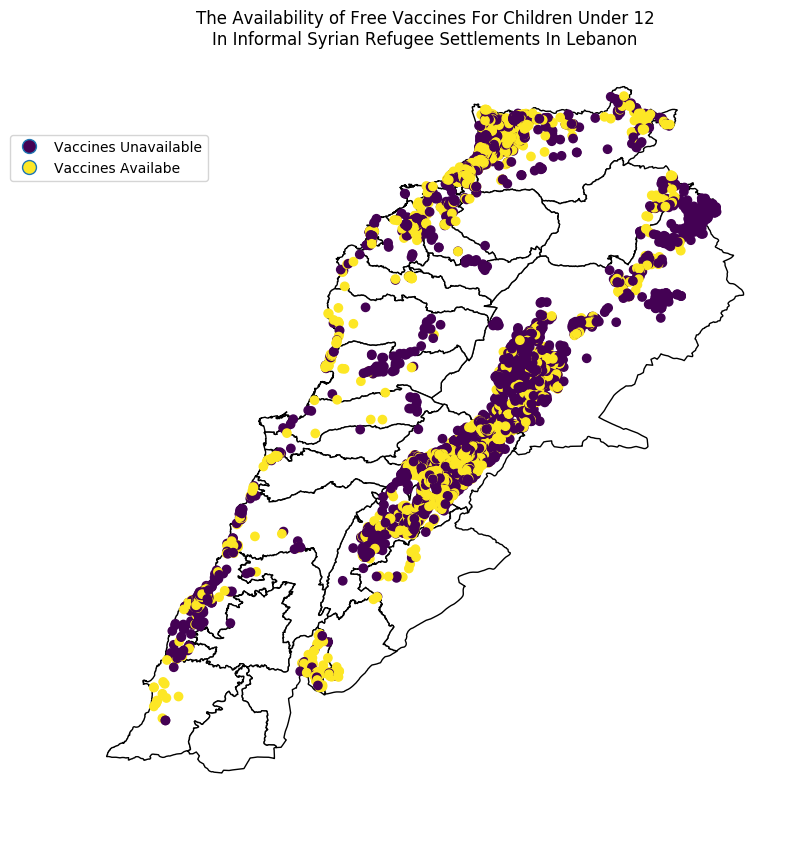

In [16]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
disshp.plot(edgecolor='k', facecolor='w', ax=ax)
df1.plot(ax=ax, column='vaccine', scheme='equal_interval',k=2, legend=True) 
         #cmap='viridis')

ax.set_aspect('equal')
ax.set_axis_off()

ax.set_title('The Availability of Free Vaccines For Children Under 12\nIn Informal Syrian Refugee Settlements In Lebanon')

ax.get_legend().set_bbox_to_anchor((.2, .9))
leg = ax.get_legend()
leg.get_texts()[0].set_text('Vaccines Unavailable')
leg.get_texts()[1].set_text('Vaccines Availabe')

**The figure above is a map of Lebanon showing the boundaries of Cazas or Districts. The locations of informal syrian refugee settlements are plotted on the map. This shows us how the settlements are concentrated in the east districts of the country as well as in those in the north. The locations are color coded by the availability of free vaccines for children under 12 years old, where dark circles indicate unavailability. We notice that a significant number of settlements lacking vaccination.**

In [17]:
fig.savefig('./Syrian_Refugee_Settlements_in_Lebanon.jpeg', dpi=100)